# **IST 718 Final Project**
### Flight Delay Predictions
Mike Carvalhero

# Install Pyspark & Load Packages

In [2]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt; plt.rcdefaults()
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import VectorIndexer
from pyspark.sql.types import FloatType
from pyspark.ml import classification
from pyspark.ml.classification import GBTClassifier
from pyspark.sql import functions as fn
from pyspark.sql.functions import abs
from pyspark.sql.functions import col, expr, when
from pyspark.sql.functions import dayofmonth
from pyspark.sql.functions import month
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# seting master("local[*]") enables multicore processing on all available logical cores on your machine
spark = SparkSession\
.builder\
.master("local[*]")\
.config("spark.memory.fraction",0.8)\
.config("spark.executor.memory","12g")\
.config("spark.driver.memory","12g")\
.config("spark.memory.offHeap.enabled",'true')\
.config("spark.memory.offHeap.size","12g")\
.config("spark.driver.maxResultSize","0")\
.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/09 16:47:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Initial Set of Questions & Predictions
Predictions:


1.   For the end user/travel booking sites - predict how likely a flight departure is to be delayed based on airline, season, origin, time of day & more
2.   For end user/airlines - predict how likely a flight arrival is to be delayed based on airline, season, origin, time of day & more
1.   For end user/travel booking sites - predict how long a flight is likely to be delayed based on predictors
2.   For end user/airlines - predict how likely a flight will have a weather delay



Inferences:
1.	Does time of day impact the chance a flight will be delayed?
2.	Does the time of year / date impact the likelihood of a delay?
3.	How do airlines compare in terms of how often delays occur?
4.	If an origin flight is in an area known for bad weather, will there be more delays?
5.	Are origins/destinations a major factor when calculating a delay likelihood?
6.	Is there an optimal time of day that flights will be least likely to delay?
7.	Which destinations are highly likely to have a delay?



In [3]:
enable_grid_search = True

# Data Source
The uncleaned data set has 28 columns and 7,213,446 rows. This data was found on Kaggle at this link the [Airline Delay and Cancellation Data](https://www.kaggle.com/datasets/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018). Some of the predictors in this data set are origin, destination airport, date of flight, airline carrier, planned departure time, distance, and a few others. The primary data set that we are working with will be the flight data from 2018. Due to the size limitation of Github uploads, we took a random sample of data from the original file with 7 million rows. The maximum reduced file that we could upload was 190,000 random rows.

The code used to create the sample:


```
new = pd.read_csv('/Users/mcarvalheiro/Desktop/IST718/2018.csv')
airline_sample = new.sample(n=190000)
airline_csv_data = airline_sample.to_csv('DelaySubset2018.csv', index = True)

```



In order to get a deeper description of certain variables, there is a separate link to the [Bureau of Transporation Statistics](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGK) that has more information. This link directs to a page that identifies the meaning of each of these variables. Variables such as WheelsOn, and TaxiIn for example are not as intuitive as DEP_TIME or ORIGIN.

Now read the 2018 csv file into a spark data frame titled 'airline_df'

In [4]:
airline_df = spark.read.csv('/Users/mcarvalheiro/Desktop/VS Code/IST718_FinalProject/data/DelaySubset2018.csv', header=True, inferSchema=True)

To verify that the data was loaded in it's entirety display the airline_df information by using .info(). If the file is being manually loaded into Google Colab, it takes awhile for the full data set to be fully loaded - the *RangeIndex:* number should be 190000.

In [5]:
display(airline_df.toPandas().info())

23/07/09 16:48:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/07/09 16:48:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , FL_DATE, OP_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST, CRS_DEP_TIME, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, CRS_ARR_TIME, ARR_TIME, ARR_DELAY, CANCELLED, CANCELLATION_CODE, DIVERTED, CRS_ELAPSED_TIME, ACTUAL_ELAPSED_TIME, AIR_TIME, DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, Unnamed: 27
 Schema: _c0, FL_DATE, OP_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST, CRS_DEP_TIME, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, CRS_ARR_TIME, ARR_TIME, ARR_DELAY, CANCELLED, CANCELLATION_CODE, DIVERTED, CRS_ELAPSED_TIME, ACTUAL_ELAPSED_TIME, AIR_TIME, DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, Unnamed: 27
E

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190000 entries, 0 to 189999
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _c0                  190000 non-null  int32  
 1   FL_DATE              190000 non-null  object 
 2   OP_CARRIER           190000 non-null  object 
 3   OP_CARRIER_FL_NUM    190000 non-null  int32  
 4   ORIGIN               190000 non-null  object 
 5   DEST                 190000 non-null  object 
 6   CRS_DEP_TIME         190000 non-null  int32  
 7   DEP_TIME             187021 non-null  float64
 8   DEP_DELAY            186881 non-null  float64
 9   TAXI_OUT             186922 non-null  float64
 10  WHEELS_OFF           186922 non-null  float64
 11  WHEELS_ON            186835 non-null  float64
 12  TAXI_IN              186835 non-null  float64
 13  CRS_ARR_TIME         190000 non-null  int32  
 14  ARR_TIME             186835 non-null  float64
 15  ARR_DELAY        

None

The most notable takeaway from this information output is that there are a lot of nulls that need to be dealt with before we are able to use this data in models. If the delay variables hae nulls - that means a delay was not recorded - so should fill the nulls of each delay variable we are focusing on (ARR_DELAY, DEP_DELAY, WEATHER_DELAY) with 0.

# Drop Unnecessary Variables
Since this data set is so massive, it would be good to consolidate the number of columns used as much as possible. The first variable that should be dropped is 'Unnamed: 27". Also, 'OP_CARRIER_FL_NUM', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', and 'TAXI_IN' are all not relevant to the testing we want to run. Can take out the delay variables as well - be sure to keep WEATHER_DELAY.

In [6]:
#Drop all variables that we are not interesting in using - then store into a new data frame
delay_df = airline_df.\
    drop('_c0', 'Unnamed: 27', 'TAXI_OUT', 'TAXI_IN', 'WHEELS_OFF',
          'WHEELS_ON', 'OP_CARRIER_FL_NUM', 'DIVERTED', 'CANCELLED',
          'CANCELLATION_CODE', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
          'CARRIER_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME')
#Look at results
delay_df.show()

+----------+----------+------+----+------------+--------+---------+------------+--------+---------+--------+--------+-------------+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|AIR_TIME|DISTANCE|WEATHER_DELAY|
+----------+----------+------+----+------------+--------+---------+------------+--------+---------+--------+--------+-------------+
|2018-04-13|        B6|   DCA| MCO|         740|   931.0|    111.0|        1001|  1135.0|     94.0|   101.0|   759.0|          0.0|
|2018-03-09|        WN|   CMH| LAS|        1650|  1648.0|     -2.0|        1820|  1821.0|      1.0|   260.0|  1771.0|         null|
|2018-08-17|        DL|   ATL| CLT|        1752|  1753.0|      1.0|        1919|  1918.0|     -1.0|    47.0|   226.0|         null|
|2018-03-14|        WN|   DAL| MSY|        1155|  1153.0|     -2.0|        1315|  1258.0|    -17.0|    55.0|   436.0|         null|
|2018-07-30|        YX|   DCA| SDF|        1850|  1849.0|     -1.0|        2

# Cleaning the Data
Extract the day of month, and the month from the FL_DATE column. These variables could provide insight to some of our initial questions.

In [ ]:
#Extract day of month, and month from the date
delay_df = delay_df.withColumn('DayOfMonth',dayofmonth(airline_df.FL_DATE))
delay_df = delay_df.withColumn('FlightMonth',month(airline_df.FL_DATE))
# delay_df.show()

### Decode Carriers
The carriers/airlines are difficult to interpret in their current form of carrier code. Should decode this to make output easier to understand during exploration.

In [ ]:
delay_df.select('OP_CARRIER').distinct().show(truncate=False)

+----------+
|OP_CARRIER|
+----------+
|UA        |
|NK        |
|AA        |
|EV        |
|B6        |
|DL        |
|OO        |
|F9        |
|YV        |
|MQ        |
|OH        |
|HA        |
|G4        |
|YX        |
|AS        |
|VX        |
|WN        |
|9E        |
+----------+



In [ ]:
carrierDic = {'AA':'American Airlines', 'AS':'Alaska Airline', 'B6':'JetBlue Airways',
              'DL':'Delta Lines Inc.', 'F9':'Frontier Airlines Inc.', 'G4':'Allegiant Air',
              'HA':'Hawaiian Airlines Inc.', 'NK':'Spirit Air Lines', 'UA':'United Air Lines Inc.',
              'VX':'Virgin America', 'WN':'Southwest Airlines Co.', 'EV':'ExpressJet Airlines LLC',
              'OO':'SkyWest Airlines Inc.', 'YV':'Mesa Airlines Inc.', 'MQ':'Envoy Air',
              'OH':'PSA Airlines Inc.', 'YX':'Republic Airline', '9E':'Endeavor Air Inc.'}

delay_df = delay_df.replace(carrierDic, subset=['OP_CARRIER'])
# delay_df.show()

In [ ]:
# display(delay_df.toPandas().info())

Check the unique values for *ORIGIN*, and *DEST*. There are a lot of unique *ORIGIN* and *DEST* values.

In [ ]:
delay_df.select('ORIGIN').distinct().count()

351

In [ ]:
delay_df.select('DEST').distinct().count()

354

# Handle the Nulls
Since weather delay is going to be used later on in one of our models, we need to replace the null values with zero. After this step is complete, we need to drop the rest of the observations that had null values. Replacing each null with zero would not work for other variables such as depart time, so discarding the rest of the observations with null values is the only solution that makes sense.

In [ ]:
#First fill all nulls in the arrival, departure, and weather delay column with 0, store results in new data frame
delay_df_fillnull = delay_df.fillna(0, subset=['WEATHER_DELAY', 'ARR_DELAY', 'DEP_DELAY'])
#From this data frame, drop all remaining nulls - models won't run otherwise
delay_nonnull = delay_df_fillnull.dropna()
# display(delay_nonnull.toPandas().info())

After dropping all null values remaining, the resulting data frame has 186,395 observations.

# Set Up Binary Target Columns Needed for Logistic Models

### Creating the Classification Targets
For this variable we are capturing if a delay was recorded as a value higher than 0 - return 1, if the value is less than or equal to 0 then return 0. Since the WEATHER_DELAY column is recorded in minutes, a positive value here means that there was a time delay due to weather. The same is done for the arrival delay and depart delay respectively.

In [ ]:
#Creating the Weather Delay Binary
IS_WEATHER_DELAY = expr(
    """IF(WEATHER_DELAY > 0, 1, 0)"""
)
delay_nonnull = delay_nonnull.withColumn("IsWeatherDelay", IS_WEATHER_DELAY)

#Creating the Depart Delay Binary
IS_DEPART_DELAY = expr(
    """IF(DEP_DELAY > 0, 1, 0)"""
)
delay_nonnull = delay_nonnull.withColumn("IsDepartDelay", IS_DEPART_DELAY )

#Creating the Arrival Delay Binary
IS_ARRIVAL_DELAY = expr(
    """IF(ARR_DELAY > 0, 1, 0)"""
)
delay_nonnull = delay_nonnull.withColumn("IsArrivalDelay", IS_ARRIVAL_DELAY)
delay_nonnull.show()

+-------------------+--------------------+------+----+------------+--------+---------+------------+--------+---------+--------+--------+-------------+----------+-----------+--------------+-------------+--------------+
|            FL_DATE|          OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|AIR_TIME|DISTANCE|WEATHER_DELAY|DayOfMonth|FlightMonth|IsWeatherDelay|IsDepartDelay|IsArrivalDelay|
+-------------------+--------------------+------+----+------------+--------+---------+------------+--------+---------+--------+--------+-------------+----------+-----------+--------------+-------------+--------------+
|2018-04-13 00:00:00|     JetBlue Airways|   DCA| MCO|         740|   931.0|    111.0|        1001|  1135.0|     94.0|   101.0|   759.0|          0.0|        13|          4|             0|            1|             1|
|2018-03-09 00:00:00|Southwest Airline...|   CMH| LAS|        1650|  1648.0|     -2.0|        1820|  1821.0|      1.0|   260.0| 

# New Variables: Binning
We are going to bin variables such as flight month, and expected depart time - see how our models may perform with one or the other.


In [ ]:
#Create a season column variable that bins based on month
delay_nonnull = delay_nonnull.withColumn('Flight_Season',
                                     when((col('FlightMonth') == 12) | (col('FlightMonth') == 1) | (col('FlightMonth') == 2), 'Winter').\
                                     when((col('FlightMonth') == 3) | (col('FlightMonth') == 4) | (col('FlightMonth') == 5), 'Spring').\
                                     when((col('FlightMonth') == 6) | (col('FlightMonth') == 7) | (col('FlightMonth') == 8), 'Summer').\
                                     when((col('FlightMonth') == 9) | (col('FlightMonth') == 10) | (col('FlightMonth') == 11), 'Autumn'))

#Create a depart time of day (TOD) column that bins expected departure time
delay_nonnull = delay_nonnull.withColumn('Flight_ExpDepTOD',
                                     when((col('CRS_DEP_TIME') >= 500) & (col('CRS_DEP_TIME') <= 1200), 'Morning').\
                                     when((col('CRS_DEP_TIME') >= 1201) & (col('CRS_DEP_TIME') <= 1700), 'Afternoon').\
                                     when((col('CRS_DEP_TIME') >= 1701) & (col('CRS_DEP_TIME') <= 2100), 'Evening').\
                                     otherwise('Night'))

#Create a arrival time of day (TOD) column that bins expected arrival time
delay_nonnull = delay_nonnull.withColumn('Flight_ExpArrTOD',
                                     when((col('CRS_ARR_TIME') >= 500) & (col('CRS_ARR_TIME') <= 1200), 'Morning').\
                                     when((col('CRS_ARR_TIME') >= 1201) & (col('CRS_ARR_TIME') <= 1700), 'Afternoon').\
                                     when((col('CRS_ARR_TIME') >= 1701) & (col('CRS_ARR_TIME') <= 2100), 'Evening').\
                                     otherwise('Night'))



# Preliminary Data Exploration Graphs
Looking at the distributions of these variables in itself can be very telling of underlying trends within the data. Creating a graph of distribution of observations by airline would be useful to see which carriers are sending out the most flights in this data set. The same should be done for city/region. It may be useful to also create a pairplot using our cleaned data.

Adding a summary table of the numeric variables is essential as well in order to get a quick understanding of the distributions of all of the variables.

## Delay by Airline

In [ ]:
#Create df that groups by airline and gets the sum of delay for each
airline_df = delay_nonnull.groupby('OP_CARRIER').agg({'IsArrivalDelay':'sum'})
#Create another df that groups by flight month and gets the count of each origin
airline_df_1 = delay_nonnull.groupby('OP_CARRIER').agg({'OP_CARRIER':'count'})
#Left join the origin_weather_df with the origin_weather_df_1
total_airline = airline_df.join(airline_df_1, on = ['OP_CARRIER'], how = 'left')
#Get the percentage of weather delays compared to total flights by origin - see how they compare
final_airline = total_airline.withColumn('PctArrivalDelay', ((fn.col('sum(IsArrivalDelay)') / fn.col('count(OP_CARRIER)') * 100))). \
                                            withColumnRenamed('sum(IsArrivalDelay)', 'TotalArrivalDelay').\
                                            withColumnRenamed('count(OP_CARRIER)', 'TotalFlights')

#Order by number of weather delays - see if areas known for bad weather are more likely to have a weather delay
final_airline = final_airline.orderBy('PctArrivalDelay', ascending = False)

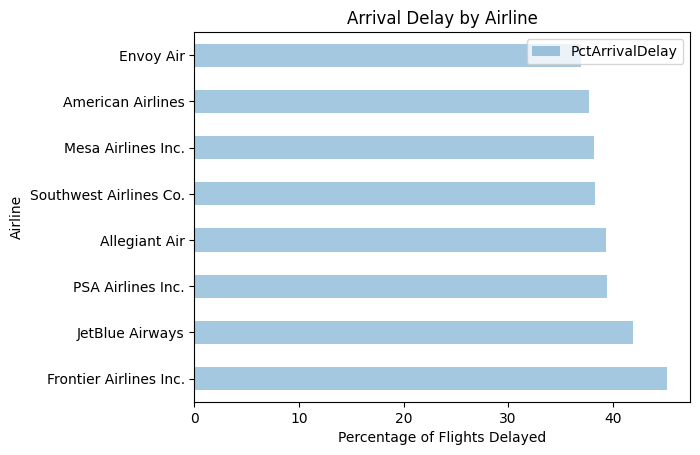

In [ ]:
#Create a bar chart that identifies the 8 highest arrival delay percentages
#Make a horizontal bar chart so that it is easier to reach the airline names
final_airline_graph = final_airline.limit(8).toPandas()
ax = final_airline_graph.plot.barh(x='OP_CARRIER', y='PctArrivalDelay', rot=0, alpha=0.4)

plt.xlabel('Percentage of Flights Delayed')
plt.ylabel('Airline')
plt.title('Arrival Delay by Airline')

plt.show()

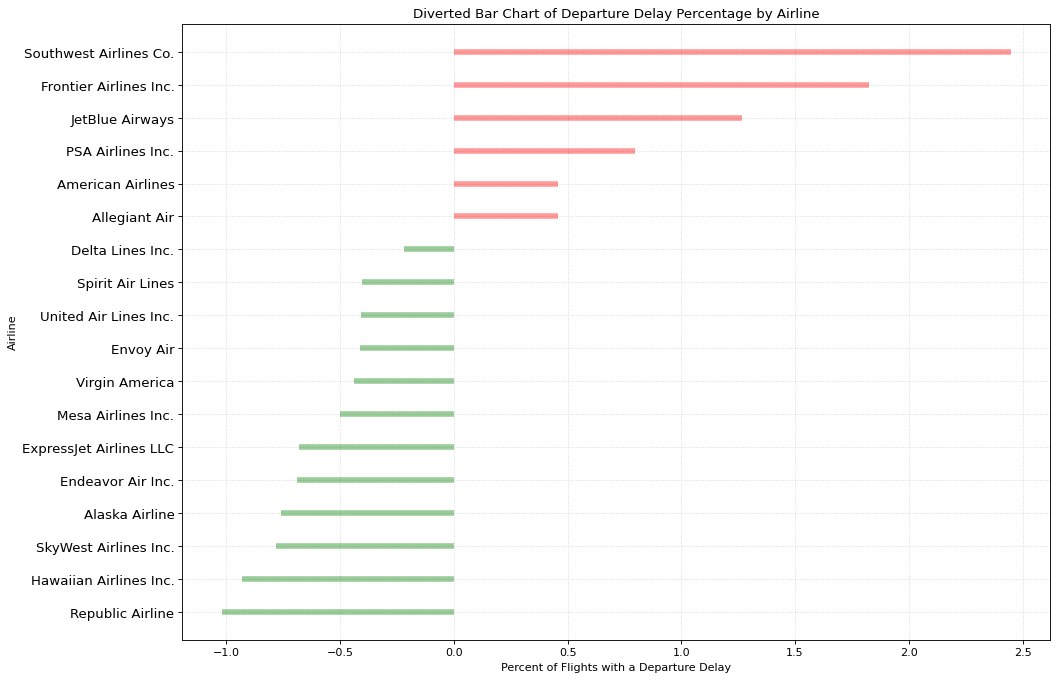

In [ ]:
#Diverging Bar Chart for Airline Departure Delay

# Prepare Data
departcount_df = delay_nonnull.groupby('OP_CARRIER').agg({'IsDepartDelay':'sum', 'OP_CARRIER':'count'})
final_depairline_df = departcount_df.withColumn('PctDepartDelay', ((fn.col('sum(IsDepartDelay)') / fn.col('count(OP_CARRIER)') * 100))). \
                                            withColumnRenamed('sum(IsDepartDelay)', 'TotalDepartureDelays').\
                                            withColumnRenamed('count(OP_CARRIER)', 'TotalFlights').toPandas()
x = final_depairline_df.loc[:, ['PctDepartDelay']]
final_depairline_df['depdelay_zscore'] = (x - x.mean())/x.std()
final_depairline_df['colors'] = ['red' if x > 0 else 'green' for x in final_depairline_df['depdelay_zscore']]
final_depairline_df.sort_values('depdelay_zscore', inplace=True)
final_depairline_df.reset_index(inplace=True)

# Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=final_depairline_df.index, xmin=0, xmax=final_depairline_df.depdelay_zscore, color=final_depairline_df.colors, alpha=0.4, linewidth=5)
plt.xlabel('Percent of Flights with a Departure Delay')
plt.ylabel('Airline')
plt.title('Diverted Bar Chart of Departure Delay Percentage by Airline')
plt.yticks(final_depairline_df.index, final_depairline_df.OP_CARRIER, fontsize=12)
plt.grid(linestyle='dotted', alpha=0.5)
plt.show()

### Arrival Delay by Airline:
1.   F9 - Frontier Airlines Inc.: 1417, 45.17%
1.   B6 - JetBlue Airways: 3216, 41.96%
1.   OH - PSA Airlines Inc.: 2793, 39.45%
1.   G4 - Allegiant Air: 1011, 39.40%
1.   WN - Southwest Airlines Co.: 13351, 38.29%
2.   YV - Mesa Airlines Inc.: 2107, 38.21%
1.   AA - American Airlines: 8964, 37.77%
2.   MQ - Envoy Air: 2754, 36.98%
2.   OO - SkyWest Airlines Inc.: 7089, 35.44%
2.   AS - Alaska Airline: 2252, 35.16%
2.   EV - ExpressJet Airlines LLC: 1847, 35.13%
1.   UA - United Air Lines Inc.: 5646, 34.67%
2.   VX - Virgin America: 149, 34.41%
2.   YX - Republic Airline: 2661, 33.33%
2.   HA - Hawaiian Airlines Inc.: 715, 32.49%
1.   NK - Spirit Air Lines: 1455, 31.45%
2.   9E - Endeavor Air Inc.: 1878, 31.18%
1.   DL - Delta Lines Inc.: 7004, 28.06%













### Departure Delay by Airline:


1.   WN - Southwest Airlines Co.: 17354, 49.77%
1.   F9 - Frontier Airlines Inc.: 1421, 45.30%
1.   B6 - JetBlue Airways: 3166, 41.30%
1.   OH - PSA Airlines Inc.: 2685, 37.92%
1.   AA - American Airlines: 8429, 35.52%
1.   G4 - Allegiant Air: 911, 35.50%
1.   DL - Delta Lines Inc.: 7653, 30.66%
1.   NK - Spirit Air Lines: 1357, 29.33%
1.   UA - United Air Lines Inc.: 4772, 29.30%
2.   MQ - Envoy Air: 2181, 29.28%
2.   VX - Virgin America: 126, 29.01%
2.   YV - Mesa Airlines Inc.: 1580, 28.65%
2.   9E - Endeavor Air Inc.: 1677, 27.84%
2.   EV - ExpressJet Airlines LLC: 1438, 27.35%
2.   AS - Alaska Airline: 1717, 26.81%
2.   OO - SkyWest Airlines Inc.: 5330, 26.65%
2.   HA - Hawaiian Airlines Inc.: 563, 25.57%
2.   YX - Republic Airline: 1990, 24.93%



## Delay by Flight Season

In [ ]:

#Create df that groups by flight season and gets the sum of isweatherdelay for each
month_weather_df = delay_nonnull.groupby('Flight_Season').agg({'IsDepartDelay':'sum'})
# month_weather_df = delay_nonnull.groupby('FlightMonth').agg({'IsWeatherDelay':'sum'})
#Create another df that groups by flight month and gets the count of each origin
month_weather_df_1 = delay_nonnull.groupby('Flight_Season').agg({'Flight_Season':'count'})
# month_weather_df_1 = delay_nonnull.groupby('FlightMonth').agg({'FlightMonth':'count'})
#Left join the origin_weather_df with the origin_weather_df_1
total_month_weather = month_weather_df.join(month_weather_df_1, on = ['Flight_Season'], how = 'left')
#Get the percentage of weather delays compared to total flights by origin - see how they compare
final_month_weather = total_month_weather.withColumn('PctFlightDelay', ((fn.col('sum(IsDepartDelay)') / fn.col('count(Flight_Season)') * 100))). \
                                            withColumnRenamed('sum(IsDepartDelay)', 'TotalDepartDelay').\
                                            withColumnRenamed('count(Flight_Season)', 'TotalFlights')

#Order by number of weather delays - see if areas known for bad weather are more likely to have a weather delay
final_month_weather.orderBy('PctFlightDelay', ascending = False).show()

+-------------+----------------+------------+------------------+
|Flight_Season|TotalDepartDelay|TotalFlights|    PctFlightDelay|
+-------------+----------------+------------+------------------+
|       Summer|           19139|       49578| 38.60381620880229|
|       Winter|           14878|       43474| 34.22275382987533|
|       Spring|           15827|       46877|33.762826119418904|
|       Autumn|           14532|       46466|31.274480265140102|
+-------------+----------------+------------+------------------+



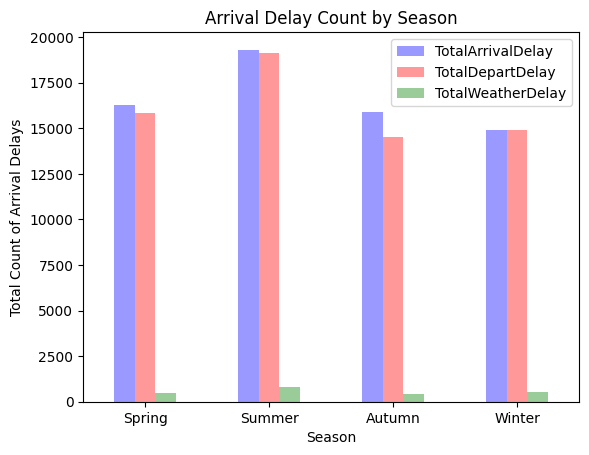

In [ ]:
#Create multi bar chart that looks at the count of each delay type for each time of day category
season_weather_df = delay_nonnull.groupby('Flight_Season').agg({'IsDepartDelay':'sum', 'IsArrivalDelay':'sum', 'IsWeatherDelay':'sum'}).\
                                withColumnRenamed('sum(IsDepartDelay)', 'TotalDepartDelay').\
                                withColumnRenamed('sum(IsArrivalDelay)', 'TotalArrivalDelay').\
                                withColumnRenamed('sum(IsWeatherDelay)', 'TotalWeatherDelay')
final_season_graph = season_weather_df.toPandas()
ax = final_season_graph.plot.bar(x='Flight_Season',rot=0, color=['blue', 'red', 'green'], alpha=0.4)

plt.xlabel('Season')
plt.ylabel('Total Count of Arrival Delays')
plt.title('Arrival Delay Count by Season')


plt.show()

### Weather Delay by Season
1.   Summer: 828, 1.67%
1.   Winter: 557, 1.28%
2.   Spring: 459, 0.98%
2.   Autumn: 442, 0.95%

### Arrival Delay by Season
1.   Summer: 19291, 38.98%
1.   Spring: 16237, 34.70%
2.   Winter: 14916, 34.34%
2.   Autumn: 15865, 34.14%

### Departure Delay by Season

1.   Summer: 19125, 38.64%
1.   Winter: 14874, 34.24%
2.   Spring: 15819, 33.81%
2.   Autumn: 14532, 31.27%

## Weather Delay by Origin

In [ ]:
#Create df that groups by origin and gets the sum of isweatherdelay for each
origin_weather_df = delay_nonnull.groupby('ORIGIN').agg({'IsWeatherDelay':'sum'})
#Create another df that groups by origin and gets the count of each origin
origin_weather_df_1 = delay_nonnull.groupby('ORIGIN').agg({'ORIGIN':'count'})
#Left join the origin_weather_df with the origin_weather_df_1
total_origin_weather = origin_weather_df.join(origin_weather_df_1, on = ['ORIGIN'], how = 'left')
#Get the percentage of weather delays compared to total flights by origin - see how they compare
final_origin_weather = total_origin_weather.withColumn('PctFlightWeatherDelay', ((fn.col('sum(IsWeatherDelay)') / fn.col('count(ORIGIN)') * 100))). \
                                            withColumnRenamed('sum(IsWeatherDelay)', 'TotalWeatherDelay').\
                                            withColumnRenamed('count(ORIGIN)', 'TotalFlights')

#add a filter on the data to only return observations with more than 5 weather delays
filter_fow_df = final_origin_weather.where(final_origin_weather.TotalWeatherDelay>5)

#Order by number of weather delays - see if areas known for bad weather are more likely to have a weather delay
filter_fow_df.orderBy('PctFlightWeatherDelay', ascending = False).show(10)

+------+-----------------+------------+---------------------+
|ORIGIN|TotalWeatherDelay|TotalFlights|PctFlightWeatherDelay|
+------+-----------------+------------+---------------------+
|   PIE|                9|         198|    4.545454545454546|
|   SFB|                9|         242|     3.71900826446281|
|   MIA|               71|        2277|   3.1181379007465964|
|   ORD|              263|        8578|     3.06598274656097|
|   JAN|                6|         218|   2.7522935779816518|
|   DFW|              182|        7149|    2.545810602881522|
|   MCO|               92|        3641|   2.5267783575940674|
|   GRR|               11|         442|     2.48868778280543|
|   XNA|                7|         310|    2.258064516129032|
|   ATL|              224|       10129|     2.21147201105736|
+------+-----------------+------------+---------------------+
only showing top 10 rows



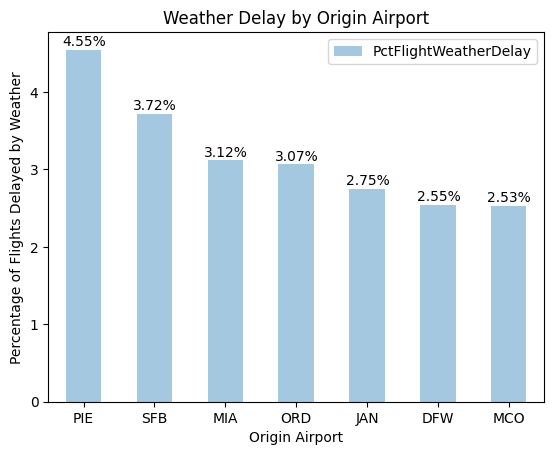

In [ ]:
#Create a bar chart that shows the highest 7 weather delay percentages by origin airport

final_origin_graph = filter_fow_df.orderBy('PctFlightWeatherDelay', ascending = False).limit(7).toPandas()
y= final_origin_graph['PctFlightWeatherDelay']
ax = final_origin_graph.plot.bar(x='ORIGIN', y='PctFlightWeatherDelay', rot=0, alpha=0.4)

plt.xlabel('Origin Airport')
plt.ylabel('Percentage of Flights Delayed by Weather')
plt.title('Weather Delay by Origin Airport')

#Add percentage values to the top of each bar
xlocs, xlabs = plt.xticks()
for i, j in enumerate(y):
    plt.text(xlocs[i] -0.3, j + 0.05, str(round(j,2)) + '%')

plt.show()

When first looking at this data frame and ordering by PctFlightWeatherDelay, it is clear that there are cases where there simply is not enough data. For example, HGR (Hagerstown, MD) has the highest percentage - but only recoreded 1 weather delay out of 6 flights. So to make sure this is no issue, the data frame was then filtered to remove rows that have less than 5 observed weather delays

### Highest Total Number of Weather Delays:
1.   ORD - Chicago, IL: 263, 3.07%
2.   ATL - Atlanta, GA: 224, 2.22%
1.   DFW - Dallas, TX: 182, 2.54%
2.   CLT - Charlotte, NC: 129, 2.19%
1.   IAH - Houston, TX: 93, 2.03 %
2.   MCO - Orlando, FL: 92, 2.53%
1.   MIA - Miami, FL: 71, 3.11%

### Highest Percentage of Flights Delayed By Weather:
1.   PIE - Clearwater, FL: 9, 4.55%
1.   SFB - Sanford, FL: 9, 3.72%
1.   MIA - Miami, FL: 71, 3.11%
1.   ORD - Chicago, IL: 263, 3.07%
2.   JAN - Jackson, MS: 6, 2.75%
2.   DFW - Dallas, TX: 182, 2.54%
2.   MCO - Orlando, FL: 92, 2.53%













## Delay by Expected Departure Time of Day

In [ ]:
#Create df that groups by time of day - for expected departure and arrival and gets the sum of delay for each
depart_df = delay_nonnull.groupby('Flight_ExpDepTOD').agg({'IsWeatherDelay':'sum'})

#Create another df that groups by time of day and gets the count of each time of day
depart_df_1 = delay_nonnull.groupby('Flight_ExpDepTOD').agg({'Flight_ExpDepTOD':'count'})

#Left join the count and delay sum dfs
total_depart = depart_df.join(depart_df_1, on = ['Flight_ExpDepTOD'], how = 'left')

#Get the percentage of weather delays compared to total flights by origin - see how they compare
final_depart = total_depart.withColumn('PctFlightDelay', ((fn.col('sum(IsWeatherDelay)') / fn.col('count(Flight_ExpDepTOD)') * 100))). \
                                            withColumnRenamed('sum(IsWeatherDelay)', 'TotalDepartDelay').\
                                            withColumnRenamed('count(Flight_ExpDepTOD)', 'TotalFlights')

#Order by number of weather delays
final_depart.orderBy('PctFlightDelay', ascending = False).show()

+----------------+----------------+------------+------------------+
|Flight_ExpDepTOD|TotalDepartDelay|TotalFlights|    PctFlightDelay|
+----------------+----------------+------------+------------------+
|         Evening|             712|       41138|1.7307598813748846|
|           Night|             180|       12179|1.4779538549963052|
|       Afternoon|             794|       54891|1.4465030697199905|
|         Morning|             600|       78187|0.7673909985035875|
+----------------+----------------+------------+------------------+



### **Arrival Delay** by **Expected Departure** Time of Day

1.   Evening: 17570, 42.75%
1.   Night: 4765, 39.16%
2.   Afternoon: 21162, 38.60%
2.   Morning: 22812, 29.21%


### **Departure Delay** by **Expected Departure** Time of Day

1.   Evening: 18142, 44.14%
1.   Night: 5061, 41.59%
2.   Afternoon: 21686, 39.56%
2.   Morning: 19461, 24.92%


### **Weather Delay** by **Expected Departure** Time of Day

1.   Evening: 712, 1.73%
1.   Night: 180, 1.48%
2.   Afternoon: 794, 1.45%
2.   Morning: 600, 0.77%


## Delay by Expected Arrival Time of Day

In [ ]:
#Create df that groups by expected arrival time of day  - sum isweatherdelay by each group
arrive_df = delay_nonnull.groupby('Flight_ExpArrTOD').agg({'IsWeatherDelay':'sum'})

#Create another df that grabs the count of each arrival time of day, group by arrival time of day
arrive_df_1 = delay_nonnull.groupby('Flight_ExpArrTOD').agg({'Flight_ExpArrTOD':'count'})

#Left join the sum of weather delays df with the count of arrival time of day df
total_arrive = arrive_df.join(arrive_df_1, on = ['Flight_ExpArrTOD'], how = 'left')

#Create a new column that gets the percentage of total flights observed in each category that encountered a weather delay
final_arrive = total_arrive.withColumn('PctFlightDelay', ((fn.col('sum(IsWeatherDelay)') / fn.col('count(Flight_ExpArrTOD)') * 100))). \
                                            withColumnRenamed('sum(IsWeatherDelay)', 'TotalWeatherDelay').\
                                            withColumnRenamed('count(Flight_ExpArrTOD)', 'TotalFlights')

#Order by the percentage
final_arrive.orderBy('PctFlightDelay', ascending = False).show()

+----------------+-----------------+------------+------------------+
|Flight_ExpArrTOD|TotalWeatherDelay|TotalFlights|    PctFlightDelay|
+----------------+-----------------+------------+------------------+
|           Night|              555|       32090|1.7295107510127767|
|         Evening|              729|       44268|1.6467877473570074|
|       Afternoon|              599|       55567|1.0779779365450717|
|         Morning|              403|       54470|0.7398568019093079|
+----------------+-----------------+------------+------------------+



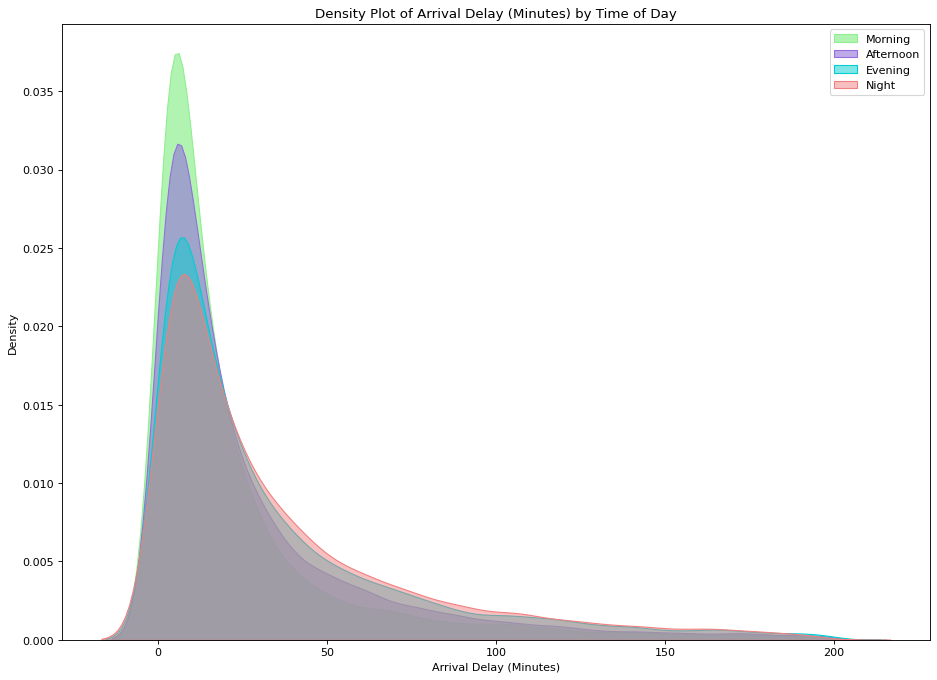

In [ ]:
#Density Plot of Arrival Delay by Time of Day
#Need to filter data frame from large values so that the plot is interpretable -  with normal df there is no way to get insights
TimeOfDayDF = delay_nonnull.where(delay_nonnull.ARR_DELAY<200).toPandas()
#Also filter so that an arrival delay is present
TimeOfDayDF = TimeOfDayDF.where(TimeOfDayDF.ARR_DELAY>0)

# Create plot
plt.figure(figsize=(14,10), dpi= 80)
sns.kdeplot(TimeOfDayDF.loc[TimeOfDayDF['Flight_ExpArrTOD'] == 'Morning', "ARR_DELAY"], shade=True, color="lightgreen", label="Morning", alpha=.7)
sns.kdeplot(TimeOfDayDF.loc[TimeOfDayDF['Flight_ExpArrTOD'] == 'Afternoon', "ARR_DELAY"], shade=True, color="mediumpurple", label="Afternoon", alpha=.6)
sns.kdeplot(TimeOfDayDF.loc[TimeOfDayDF['Flight_ExpArrTOD'] == 'Evening', "ARR_DELAY"], shade=True, color="darkturquoise", label="Evening", alpha=.5)
sns.kdeplot(TimeOfDayDF.loc[TimeOfDayDF['Flight_ExpArrTOD'] == 'Night', "ARR_DELAY"], shade=True, color="lightcoral", label="Night", alpha=.5)

plt.xlabel('Arrival Delay (Minutes)')
plt.title('Density Plot of Arrival Delay (Minutes) by Time of Day')
plt.legend()
plt.show()

### ***Arrival Delay*** by ***Expected Arrival*** Time of Day

1.   Night: 13581, 42.35%
1.   Evening: 18620, 42.11%
2.   Afternoon: 19101, 34.41%
2.   Morning: 15007, 27.59%


### ***Departure Delay*** by ***Expected Arrival*** Time of Day

1.   Night: 14343, 44.73%
1.   Evening: 19015, 43.01%
2.   Afternoon: 19190, 34.57%
2.   Morning: 11802, 21.70%


### ***Weather Delay*** by ***Expected Arrival*** Time of Day

1.   Night: 555, 1.73%
1.   Evening: 729, 1.65%
2.   Afternoon: 599, 1.08%
2.   Morning: 403, 0.74%

# Feature Engineering Pipeline
Need to use stringIndexer on *ORIGIN*, *DEST*, & *OP_CARRIER*. Additionally need to assemble a features vector using vectorAssembler.

In [ ]:
# THE ORIGINAL PIPELINE
feature_engineering_pipe = Pipeline(stages=[feature.StringIndexer(inputCol="OP_CARRIER", outputCol='Airline'),
                                       feature.StringIndexer(inputCol='Flight_Season', outputCol = 'Season'),
                                       feature.StringIndexer(inputCol='Flight_ExpDepTOD', outputCol = 'ExpectDepartTOD'),
                                       feature.StringIndexer(inputCol='Flight_ExpArrTOD', outputCol = 'ExpectArrivalTOD'),
                                       feature.StringIndexer(inputCol='ORIGIN', outputCol = 'Origin'),
                                       feature.StringIndexer(inputCol='DEST', outputCol = 'Dest')])

delay_df_xformed = feature_engineering_pipe.fit(delay_nonnull).transform(delay_nonnull).\
                                                withColumnRenamed('CRS_DEP_TIME', 'ExpectedDepartTime').\
                                                withColumnRenamed('CRS_ARR_TIME', 'ExpectedArrivalTime').\
                                                withColumnRenamed('DEP_DELAY', 'DepartDelay').\
                                                withColumnRenamed('ARR_DELAY', 'ArrivalDelay').\
                                                withColumnRenamed('DISTANCE', 'Distance').\
                                                withColumnRenamed('AIR_TIME', 'AirTime').\
                                                drop('OP_CARRIER', 'FL_DATE', 'ARR_TIME', 'Flight_Season', 'Flight_ExpDepTOD', 'Flight_ExpArrTOD', 'DEP_TIME')


In [ ]:
#Tried one hot encoding - made a negative difference for model performance on certain models - so sticking with string indexer

# feature_engineering_pipe = Pipeline(stages=[feature.StringIndexer(inputCol="OP_CARRIER", outputCol='SIAirline'),
#                                         feature.StringIndexer(inputCol='ORIGIN', outputCol = 'SIOrigin'),
#                                         feature.StringIndexer(inputCol='DEST', outputCol = 'SIDest'),
#                                         feature.StringIndexer(inputCol='Flight_Season', outputCol = 'Season'),
#                                         feature.StringIndexer(inputCol='Flight_ExpDepTOD', outputCol = 'ExpectDepartTOD'),
#                                         feature.StringIndexer(inputCol='Flight_ExpArrTOD', outputCol = 'ExpectArrivalTOD'),
#                                         feature.OneHotEncoder(inputCol="SIAirline", outputCol='Airline'),
#                                         feature.OneHotEncoder(inputCol='SIOrigin', outputCol = 'Origin'),
#                                         feature.OneHotEncoder(inputCol='SIDest', outputCol = 'Dest')])

# delay_df_xformed = feature_engineering_pipe.fit(delay_nonnull).transform(delay_nonnull).\
#                                                 withColumnRenamed('CRS_DEP_TIME', 'ExpectedDepartTime').\
#                                                 withColumnRenamed('CRS_ARR_TIME', 'ExpectedArrivalTime').\
#                                                 withColumnRenamed('DEP_DELAY', 'DepartDelay').\
#                                                 withColumnRenamed('ARR_DELAY', 'ArrivalDelay').\
#                                                 withColumnRenamed('DISTANCE', 'Distance').\
#                                                 withColumnRenamed('AIR_TIME', 'AirTime').\
#                                                 drop('OP_CARRIER', 'FL_DATE', 'ARR_TIME', 'WEATHER_DELAY', 'Flight_Season', 'Flight_ExpDepTOD', 'Flight_ExpArrTOD', 'DEP_TIME')

### Pair Plot
This pair plot does not provide us with many great insights because of the size of the data - and the number of categories in some of our variables. A correlation matrix will be easier to interpret

In [ ]:
# df = delay_df_xformed.toPandas()
# sns.pairplot(df, vars = ["Airline","Origin","Dest","ExpectedDepartTime","ActualDepartTime","ExpectedArrivalTime","AirTime","Distance",
#                          "DayOfMonth","FlightMonth"], dropna = True)

### Correlation Matrix

In [ ]:
#Develop correlation matrix
initial_corr_df = delay_df_xformed.drop('IsWeatherDelay', 'IsDepartDelay', 'IsArrivalDelay').toPandas()
corr = initial_corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Origin,Dest,ExpectedDepartTime,DepartDelay,ExpectedArrivalTime,ArrivalDelay,AirTime,Distance,WEATHER_DELAY,DayOfMonth,FlightMonth,Airline,Season,ExpectDepartTOD,ExpectArrivalTOD
Origin,1.000000,-0.166013,-0.125205,-0.013575,-0.112336,-0.001532,-0.188420,-0.196935,0.001453,0.002229,0.003152,0.163538,-0.004038,-0.096285,-0.100540
Dest,-0.166013,1.000000,0.133582,-0.006207,0.094214,0.005283,-0.210726,-0.197093,0.013687,0.002561,0.000694,0.160791,-0.005255,0.100386,0.044166
ExpectedDepartTime,-0.125205,0.133582,1.000000,0.103203,0.688216,0.093373,-0.017682,-0.011254,0.017986,-0.003759,-0.003419,-0.001302,-0.003010,0.896921,0.642325
DepartDelay,-0.013575,-0.006207,0.103203,1.000000,0.087690,0.956507,0.006751,0.007258,0.289155,-0.006273,-0.000743,0.004335,-0.031690,0.096595,0.078888
ExpectedArrivalTime,-0.112336,0.094214,0.688216,0.087690,1.000000,0.082148,0.018182,0.015342,0.015671,-0.005224,0.001823,-0.000906,0.015680,0.569140,0.495739
ArrivalDelay,-0.001532,0.005283,0.093373,0.956507,0.082148,1.000000,-0.004218,-0.021246,0.289353,-0.007141,0.010041,0.026989,-0.040689,0.085773,0.071633
AirTime,-0.188420,-0.210726,-0.017682,0.006751,0.018182,-0.004218,1.000000,0.984835,-0.007517,0.001019,-0.001964,-0.039636,-0.004164,0.001081,0.058887
Distance,-0.196935,-0.197093,-0.011254,0.007258,0.015342,-0.021246,0.984835,1.000000,-0.009452,0.000956,0.002102,-0.045288,-0.013073,0.012638,0.065034
WEATHER_DELAY,0.001453,0.013687,0.017986,0.289155,0.015671,0.289353,-0.007517,-0.009452,1.000000,-0.001329,-0.000052,0.002162,-0.005581,0.017520,0.017027
DayOfMonth,0.002229,0.002561,-0.003759,-0.006273,-0.005224,-0.007141,0.001019,0.000956,-0.001329,1.000000,0.004654,0.000311,-0.016167,-0.000661,0.000876


ExpectedDepartTime and ActualDepartTime are naturally highly correlated, if we keep variables in that are highly correlated then we are unable to interpret the coefficients. This is the multicollinearity issue. The same can be said about DepartDelay and ArrivalDelay - so these cannot be predictors for any model. AirTime and Distance also are highly correlated, which intuitively makes sense - so we should drop AirTime in regression models. Also models should choose the variables expected depart time & expected arrival time, or expected depart tod and expect arrival tod. Should not have all 4 variables. Since the expected arrival time and expected departure time are more correlated with the delay variables we are looking at - we should drop the TOD variables.

In [ ]:
#Drop remaining variables that are not needed for models
delay_df_xformed = delay_df_xformed.drop('ExpectDepartTOD', 'ExpectArrivalTOD', 'WEATHER_DELAY', 'AirTime')

### Summary Table for Remaining Clean Variables

In [ ]:
delay_df_xformed.summary().show()

+-------+-----------------+-----------------+------------------+-----------------+-------------------+-----------------+-----------------+------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+
|summary|           Origin|             Dest|ExpectedDepartTime|      DepartDelay|ExpectedArrivalTime|     ArrivalDelay|         Distance|        DayOfMonth|       FlightMonth|      IsWeatherDelay|     IsDepartDelay|    IsArrivalDelay|          Airline|            Season|
+-------+-----------------+-----------------+------------------+-----------------+-------------------+-----------------+-----------------+------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+
|  count|           186395|           186395|            186395|           186395|             186395|           186395|           186395|            186395|            186395|     

# Linear Regression Model: Predicting How Long a Delay Will Be
With the continuous variable, *ARR_DELAY*, we are able to see by how many minutes a flight's arrival time was delayed (The difference between expected arrival time *CRS_ARR_TIME* and actual arrival time *ARR_TIME*). In order to create a model that can predict how many minutes a flight will be delayed, this arrival delay variable will need to be the dependent variable in a linear regression model.

In [ ]:
# Split Data
training_df, validation_df, testing_df = delay_df_xformed.randomSplit([0.6, 0.3, 0.1], )

### Linear Regression Model: Duration of Arrival Delay Prediction

In [ ]:
# Create Vector Assembler and Linear Regression model
va = feature.VectorAssembler(inputCols = ['Airline', 'Origin', 'Dest', 'Season',
                                          'Distance', 'DayOfMonth', 'ExpectedDepartTime',
                                          'ExpectedArrivalTime', 'FlightMonth'],
                             outputCol='features')
lr = regression.LinearRegression(featuresCol = 'features', labelCol = 'ArrivalDelay')
# Fit Pipe to Training data
arr_delay_pipe = Pipeline(stages = [va, lr]).fit(training_df)
# Evaluate MSE score of the Linear Regression model
ev = RegressionEvaluator(metricName = 'mse', predictionCol = 'prediction', labelCol = 'ArrivalDelay')
ev.evaluate(arr_delay_pipe.transform(validation_df))

2306.3149040705703

In [ ]:
lr_pipeline = Pipeline(stages = [va, lr])
if enable_grid_search:
      # Create grid
      lr_grid = ParamGridBuilder().\
      addGrid(lr.regParam, [0.1, 0.00001]).\
      addGrid(lr.elasticNetParam, [0.0, 0.5, 1]).\
      build()

      # Grid search - fit with training data
      lr_all_models = []
      for j in range(len(lr_grid)):
        lr_model = lr_pipeline.fit(training_df, lr_grid[j])
        lr_all_models.append(lr_model)

      # Get the MSE scores of each model on the grid
      # Create empty list that will be appended
      lr_MSE_Scores = []
      # For each model in all models on the grid - obtain the MSE score
      for m in lr_all_models:
        lr_predictions = m.transform(validation_df)
        lr_MSE_score = ev.evaluate(lr_predictions, {ev.metricName: "mse"})
        lr_MSE_Scores.append(lr_MSE_score)

      # Get index of the best model by using function argmin - the lower the MSE score the better
      best_lr_model_idx = np.argmin(lr_MSE_Scores)
      best_lr_model = lr_all_models[best_lr_model_idx]

      # Look at the corresponding grid index to find the hyper parameter values in the best model
      print(lr_grid[best_lr_model_idx])
      print("MSE on Validation Data = ", lr_MSE_Scores[best_lr_model_idx])
      pass

{Param(parent='LinearRegression_a3ccf0ae8928', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LinearRegression_a3ccf0ae8928', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}
MSE on Validation Data =  2306.314518160212


In [ ]:
#Hard code best Linear Regression model
tuned_lr = regression.LinearRegression(featuresCol = 'features', labelCol = 'ArrivalDelay', regParam=0.01, elasticNetParam=0.05)
tuned_lr_pipe = Pipeline(stages=[va, tuned_lr]).fit(training_df)
tuned_lr_mse = ev.evaluate(tuned_lr_pipe.transform(validation_df))
# evaluate MSE on Testing data
ev.evaluate(tuned_lr_pipe.transform(testing_df))

1974.8701341728365

In [ ]:
# Create dataframe with Feature Weights
feature_coeff = arr_delay_pipe.stages[-1].coefficients.toArray()
feature_weight = {'coefficient': ['Airline', 'Origin', 'Dest', 'Season',
                                  'Distance', 'DayOfMonth', 'ExpectedDepartTime',
                                  'ExpectedArrivalTime', 'FlightMonth']
                  , 'weight': np.abs(feature_coeff)}
feature_weight_df = pd.DataFrame(data = feature_weight)
feature_weight_df = feature_weight_df.sort_values('weight', ascending = False)
feature_weight_df

,coefficient,weight
3,Season,1.764727
0,Airline,0.343640
8,FlightMonth,0.143268
5,DayOfMonth,0.036434
2,Dest,0.014508
6,ExpectedDepartTime,0.006731
7,ExpectedArrivalTime,0.003418
1,Origin,0.001903
4,Distance,0.001750


In [ ]:
# Show some predictions from Linear Regression model
arr_delay_pred = arr_delay_pipe.transform(testing_df)
#arr_delay_pred.select('ArrivalDelay', 'prediction').show(20)

In [ ]:
# Create a StandardScaler and a Scaled Linear Regression Model
sc = feature.StandardScaler(inputCol = 'features', outputCol = 'scaled_features',
                            withMean = True, withStd = True)
lr_scaled = regression.LinearRegression(featuresCol = 'scaled_features', labelCol = 'ArrivalDelay')
# Fit Pipe to Training data
arr_delay_pipe_4 = Pipeline(stages=[va, sc, lr_scaled]).fit(training_df)
# Evaluate on Validation data
ev.evaluate(arr_delay_pipe_4.transform(validation_df))

2306.3149040705694

In [ ]:
# Create dataframe with Feature Weights
feature_coeff_2 = arr_delay_pipe_4.stages[-1].coefficients.toArray()
feature_weight_2 = {'coefficient': ['Airline', 'Origin', 'Dest', 'Season',
                                  'Distance', 'DayOfMonth', 'ExpectedDepartTime',
                                  'ExpectedArrivalTime', 'FlightMonth']
                  , 'weight': np.abs(feature_coeff_2)}
feature_weight_df_2 = pd.DataFrame(data = feature_weight_2)
feature_weight_df_2 = feature_weight_df_2.sort_values('weight', ascending = False)
feature_weight_df_2

,coefficient,weight
6,ExpectedDepartTime,3.304841
3,Season,1.972916
7,ExpectedArrivalTime,1.774120
0,Airline,1.485147
4,Distance,1.046970
2,Dest,0.699522
8,FlightMonth,0.485661
5,DayOfMonth,0.319226
1,Origin,0.091461


In [ ]:
# Show some predictions from Scaled Linear Regression Model
arr_delay_pred_4 = arr_delay_pipe_4.transform(testing_df)
#arr_delay_pred_4.select('ArrivalDelay', 'prediction').show(20)

### Random Forest Regression Model: Duration of Arrival Delay Prediction

In [ ]:
# Create Vector Indexer and Random Forest Regression Model
feature_idx = VectorIndexer(inputCol = 'features', outputCol = 'indexedFeatures')
rf = regression.RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'ArrivalDelay', maxBins = 354)
# Fit Pipe to Training data
arr_delay_pipe_2 = Pipeline(stages = [va, feature_idx, rf]).fit(training_df)
# Evaluate MSE of Random Forest Regression Model
ev.evaluate(arr_delay_pipe_2.transform(validation_df))

2310.6668735345575

In [ ]:
rf_pipeline = Pipeline(stages = [va, feature_idx, rf])
if enable_grid_search:
  # Build grid
    grid = ParamGridBuilder().\
    addGrid(rf.numTrees, [30, 70]).\
    addGrid(rf.maxDepth, [5, 10]).\
    build()

  # Grid search
    all_models = []
    for j in range(len(grid)):
      model = rf_pipeline.fit(training_df, grid[j])
      all_models.append(model)

    # Get the MSE scores of each model on the grid
    # Create empty list that will be appended
    mse_scores = []
    # For each model in all models on the grid - obtain the MSE score using a RegressionEvaluator
    for m in all_models:
      predictions = m.transform(validation_df)
      evaluator = RegressionEvaluator(labelCol="ArrivalDelay", predictionCol="prediction", metricName="mse")
      mse = evaluator.evaluate(predictions)
      mse_scores.append(mse)

    # Get index of the best model by using function argmin - lower MSE is better
    best_model_idx = np.argmin(mse_scores)
    best_model = all_models[best_model_idx]

    # Print the best model parameters
    print(grid[best_model_idx])
    # Print the MSE score of the best model
    print("Mean Squared Error (MSE) on Validation Data = ", mse_scores[best_model_idx])
    pass

{Param(parent='RandomForestRegressor_8ecf277db41b', name='numTrees', doc='Number of trees to train (>= 1).'): 30, Param(parent='RandomForestRegressor_8ecf277db41b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5}
Mean Squared Error (MSE) on Validation Data =  2306.3939109620405


In [ ]:
# Hard code parameter values for Random Forest Regressor model
nt = 30
md = 5
mb = 354

# Create new random forest regressor with hard coded best model hyper params
tuned_rf = regression.RandomForestRegressor().\
    setLabelCol('ArrivalDelay').\
    setFeaturesCol('indexedFeatures').\
    setNumTrees(nt).\
    setMaxBins(mb).\
    setMaxDepth(md)

# Create the pipeline
tuned_rf_pipe = Pipeline(stages=[va, feature_idx, tuned_rf]).fit(training_df)
tuned_rf_mse = ev.evaluate(tuned_rf_pipe.transform(validation_df))
# Evaluate MSE on Testing data
ev.evaluate(tuned_rf_pipe.transform(testing_df))

1979.6603825369368

In [ ]:
# Show some predictions from Random Forest Regression Model
arr_delay_pred_2 = arr_delay_pipe_2.transform(testing_df)
#arr_delay_pred_2.select('ArrivalDelay', 'prediction').show(20)

In [ ]:
# Create dataframe with Feature Importances
rf_arr_delay = arr_delay_pipe_2.stages[-1]
arr_delay_array = rf_arr_delay.featureImportances.toArray()
arr_delay_abs = np.abs(arr_delay_array)

feature_imp_df = pd.DataFrame(list(zip(arr_delay_pred_2.drop('prediction', 'IsWeatherDelay', 'ExpectDepartTOD',
                                                'ExpectArrivalTOD', 'ArrivalDelay', 'DepartDelay',
                                                'AirTime', 'features', 'indexedFeatures', 'IsDepartDelay',
                                                'IsArrivalDelay').columns, arr_delay_abs)),
                     columns = ['feature', 'importance']).sort_values('importance', ascending = False)

feature_imp_df

,feature,importance
1,Dest,0.294572
2,ExpectedDepartTime,0.249669
6,FlightMonth,0.127804
7,Airline,0.098021
8,Season,0.081293
0,Origin,0.071029
5,DayOfMonth,0.035147
3,ExpectedArrivalTime,0.022232
4,Distance,0.020233


### Gradient-Boosted Trees Regression Model: Duration of Arrival Delay Prediction

In [ ]:
# Create Gradient-Boosted Tree Regression Model
gbt = regression.GBTRegressor(featuresCol = 'indexedFeatures', labelCol = 'ArrivalDelay', maxBins = 354)
# Fit Pipe to Training data
arr_delay_pipe_3 = Pipeline(stages = [va, feature_idx, gbt]).fit(training_df)
# Evaluate MSE of GBT Regression Model
ev.evaluate(arr_delay_pipe_3.transform(validation_df))

2488.705038547405

In [ ]:
gbt_pipeline = Pipeline(stages = [va, feature_idx, gbt])
if enable_grid_search:
  # Build grid
    grid = ParamGridBuilder().\
    addGrid(gbt.subsamplingRate, [0.85]).\
    addGrid(gbt.maxIter, [90]).\
    addGrid(gbt.stepSize, [0.14, 0.15, 0.16]).\
    addGrid(gbt.maxDepth, [4]).\
    build()

  # Grid search
    all_models = []
    for j in range(len(grid)):
      model = gbt_pipeline.fit(training_df, grid[j])
      all_models.append(model)

    # Get the MSE scores of each model on the grid
    # Create empty list that will be appended
    gbt_mse_scores = []
    # For each model in all models on the grid - obtain the MSE score using a RegressionEvaluator
    for m in all_models:
      predictions = m.transform(validation_df)
      evaluator = RegressionEvaluator(labelCol="ArrivalDelay", predictionCol="prediction", metricName="mse")
      mse = evaluator.evaluate(predictions)
      gbt_mse_scores.append(mse)

    # Get index of the best model by using function argmin - lower MSE is better
    best_model_idx = np.argmin(gbt_mse_scores)
    best_model = all_models[best_model_idx]

    # Print the best model parameters
    print(grid[best_model_idx])
    # Print the MSE score of the best model
    print("Mean Squared Error (MSE) on Validation Data = ", gbt_mse_scores[best_model_idx])
    pass

{Param(parent='GBTRegressor_8e13f81810e3', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 0.85, Param(parent='GBTRegressor_8e13f81810e3', name='maxIter', doc='max number of iterations (>= 0).'): 90, Param(parent='GBTRegressor_8e13f81810e3', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.14, Param(parent='GBTRegressor_8e13f81810e3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4}
Mean Squared Error (MSE) on Validation Data =  2524.1483241367405


In [ ]:
# Hard code parameter values for GBT Regression model
ssr = 0.85
mi = 90
ss = 0.14
md = 4
mb= 354

# Create new random forest regressor with hard coded best model hyper params
tuned_gbt = regression.GBTRegressor().\
    setLabelCol('ArrivalDelay').\
    setFeaturesCol('indexedFeatures').\
    setSubsamplingRate(ssr).\
    setMaxIter(mi).\
    setStepSize(ss).\
    setMaxBins(mb).\
    setMaxDepth(md)

# Create the pipeline
tuned_gbt_pipe = Pipeline(stages=[va, feature_idx, tuned_gbt]).fit(training_df)
tuned_gbt_mse = ev.evaluate(tuned_gbt_pipe.transform(validation_df))
# Evaluate MSE on Testing data
ev.evaluate(tuned_gbt_pipe.transform(testing_df))

2201.3275545342276

In [ ]:
# Show some predictions from GBT Regression Model
arr_delay_pred_3 = arr_delay_pipe_3.transform(testing_df)
#arr_delay_pred_3.select('ArrivalDelay', 'prediction').show(20)

In [ ]:
# Create dataframe with Feature Importances
gbt_arr_delay = arr_delay_pipe_3.stages[-1]
arr_delay_array_2 = gbt_arr_delay.featureImportances.toArray()
arr_delay_abs_2 = np.abs(arr_delay_array)

feature_imp_df_2 = pd.DataFrame(list(zip(arr_delay_pred_3.drop('prediction', 'IsWeatherDelay', 'ExpectedDepartTime',
                                                'ExpectedArrivalTime', 'ArrivalDelay', 'DepartDelay',
                                                'AirTime', 'features', 'indexedFeatures', 'IsDepartDelay',
                                                'IsArrivalDelay').columns,
                              arr_delay_abs_2)),
                     columns = ['feature', 'importance']).sort_values('importance', ascending = False)

feature_imp_df_2

,feature,importance
1,Dest,0.294572
2,Distance,0.249669
6,Season,0.127804
0,Origin,0.071029
5,Airline,0.035147
3,DayOfMonth,0.022232
4,FlightMonth,0.020233


In [ ]:
# Create model comparison df
#Create list with specified model labels
labels = ['Unscaled LR', 'Scaled LR', 'RF', 'GBT']
u_lr_mse = tuned_lr_mse
s_lr_mse = ev.evaluate(arr_delay_pipe_4.transform(validation_df))
rf_MSE = tuned_rf_mse
gbt_MSE = tuned_gbt_mse
#Create list of results from each model
scores = [u_lr_mse, s_lr_mse, rf_MSE, gbt_MSE]
#Zip the two lists together, and sort values by MSE in descending order - highest at the top
#Had to round the df to the nearest 2 decimals, otherwise MSE value output was returned in scientific notation
arrival_delay_compare_df = pd.DataFrame(list(zip(labels, scores)),
            columns = ['Model', 'MSE']).sort_values('MSE', ascending = True).round(4)

#Return output
display(arrival_delay_compare_df)

,Model,MSE
0,Unscaled LR,2306.3147
1,Scaled LR,2306.3149
2,RF,2306.3939
3,GBT,2524.1483


# Logistic Regression Model: Predicting Likelihood a Flight Will Be Delayed
Aside from a linear regression model that can predict how many minutes delayed (or early) a given flight may be, it is also beneficial to predict the probability that a flight will be delayed in general. This could be applicable to customers who would like delay alerts - if the probability hits a certain threshold, notify the customer that there is a risk of getting on this flight (for example, may impact connecting flights). To do this, create a variable called *IS_DELAY* that returns 1 if there was a delay, and 0 if there was not a delay (*ARR_DELAY* > 0). Use *IS_DELAY* as the target variable, and the remaining values other than *ARR_DELAY* should be VectorAssembled into the 'features' column.

Create the new variable, then create the pipeline using LogisticRegression other than LinearRegression as used above.



In [ ]:
arr_delay_df = delay_df_xformed.withColumnRenamed('IsArrivalDelay', 'label')
a_training_df, a_validation_df, a_testing_df = arr_delay_df.randomSplit([0.6, 0.3, 0.1], )

### Logisitc Regression Model: Arrival Delay Prediction

In [ ]:
logr = LogisticRegression(regParam=0.37,elasticNetParam=0.2)
logr_pipeline2 = Pipeline(stages=[va, logr]).fit(a_training_df)
bce = BinaryClassificationEvaluator()
bce.evaluate(logr_pipeline2.transform(a_validation_df))

0.5

In [ ]:
logr_pipeline = Pipeline(stages=[va, logr])

if enable_grid_search:
      #Create grid
      alogr_grid = ParamGridBuilder().\
      addGrid(logr.regParam, [0.22, 0.25, 0.28]).\
      addGrid(logr.elasticNetParam, [0.0065, 0.0075, 0.0085]).\
      build()

      #Grid search - fit with training data
      alogr_all_models = []
      for j in range(len(alogr_grid)):
        alogr_model = logr_pipeline.fit(a_training_df, alogr_grid[j])
        alogr_all_models.append(alogr_model)

      #Get the MSE scores of each model on the grid
      #Create empty list that will be appended
      alogr_AUC_Scores = []
      #For each model in all models on the grid - obtain the MSE score
      for m in alogr_all_models:
        alogr_predictions = m.transform(a_validation_df)
        alogr_AUC_score = bce.evaluate(alogr_predictions, {bce.metricName: "areaUnderROC"})
        alogr_AUC_Scores.append(alogr_AUC_score)

      #Get index of the best model by using function argmin - the lower the AUC score the better
      best_alogr_model_idx = np.argmax(alogr_AUC_Scores)
      best_alogr_model = alogr_all_models[best_alogr_model_idx]

      #Look at the corresponding grid index to find the hyper parameter values in the best model
      print(alogr_grid[best_alogr_model_idx])
      print("AUC on Validation Data = ", alogr_AUC_Scores[best_alogr_model_idx])
      pass


### Random Forest Classification Model: Arrival Delay Prediction

In [ ]:
rfc = RandomForestClassifier(maxBins=354)
rfc_pipeline = Pipeline(stages=[va, rfc]).fit(a_training_df)
bce.evaluate(rfc_pipeline.transform(a_validation_df))

0.5882002776971613

In [ ]:
# see https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve


# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter,
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2,
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


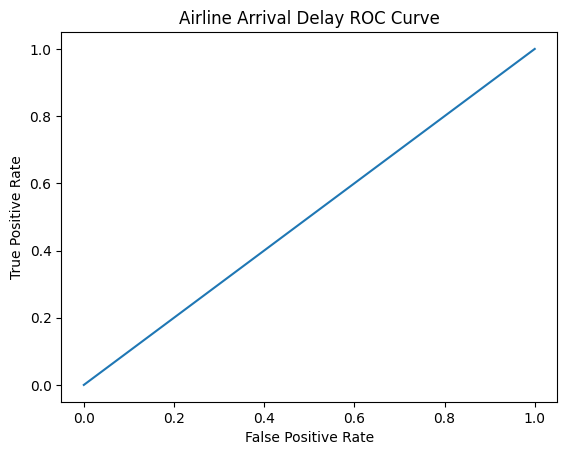

In [ ]:
# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = logr_pipeline2.transform(a_testing_df)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Airline Arrival Delay ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [ ]:
logr_model = logr_pipeline2.stages[-1]

rfc_model = rfc_pipeline.stages[-1]

delay_array = rfc_model.featureImportances.toArray()

delay_abs = np.abs(delay_array)

In [ ]:
rf2_df = pd.DataFrame(list(zip(arr_delay_df.drop('label', 'IsDepartDelay', 'IsWeatherDelay', 'ArrivalDelay', 'ArrivalDelay', 'DepartDelay',
                                                'features', 'indexedFeatures', 'IsDepartDelay',
                                                'IsArrivalDelay').columns, delay_abs)),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

display(rf2_df)

,feature,importance
6,FlightMonth,0.375631
7,Airline,0.320257
0,Origin,0.100140
3,ExpectedArrivalTime,0.074577
1,Dest,0.062431
2,ExpectedDepartTime,0.047873
8,Season,0.009426
4,Distance,0.008023
5,DayOfMonth,0.001642


In [ ]:
# Create model comparison df
#Create list with specified model labels
labels = ['LogR', 'RF']
logree_mse = alogr_AUC_Scores[best_alogr_model_idx]
rf_MSE2 = bce.evaluate(rfc_pipeline.transform(a_validation_df))

#Create list of results from each model
scores = [logree_mse, rf_MSE2]
#Zip the two lists together, and sort values by AUC in descending order - highest at the top
#Had to round the df to the nearest 2 decimals, otherwise AUC value output was returned in scientific notation
l_delay_compare_df = pd.DataFrame(list(zip(labels, scores)),
            columns = ['Model', 'AUC']).sort_values('AUC', ascending = True).round(4)

#Return output
display(l_delay_compare_df)

,Model,AUC
0,LogR,0.5743
1,RF,0.5882


# Logistic Regression Model: Predicting Likelihood a Flight Will Be Delayed By Weather
A general logistic model is fantastic for a general likelihood prediction and is easier to capture in general - but since there is a variable called *WEATHER_DELAY* we can create a prediction model that indicates the predicted chance of a weather delay occurring. The same general steps of the first logistic model are applied here, but this time we are creating a new binary variable based on the *WEATHER_DELAY* column. If the variable is a positive number (>0.0) then return 1, if the variable is <=0 or null then return 0.




In [ ]:
#Create specific data frame for this section - set IsWeatherDelay as label because this is the necessary binary target
weather_df = delay_df_xformed.withColumnRenamed('IsWeatherDelay', 'label')
#Split up new df with portions consistent to other models
wd_training_df, wd_validation_df, wd_testing_df = weather_df.randomSplit([0.6, 0.3, 0.1], )

In [ ]:
#Run first simple logistic regression model
wlogr = LogisticRegression(regParam=0.1)
#Fit with training df, use va from the linear regression model above - using the same set of features
wlogr_pipeline = Pipeline(stages=[va, wlogr]).fit(wd_training_df)
#Define the evaluator
bce = BinaryClassificationEvaluator()
#Evaluate on the validation df using AUC as the metric
bce.evaluate(wlogr_pipeline.transform(wd_validation_df), {bce.metricName: "areaUnderROC"})

0.6301834715465717

In [ ]:
#Create a predictions data set and only select the true values and prediction values
prf = wlogr_pipeline.transform(wd_testing_df).select('label', 'prediction')
#Find the count of true positives, true negatives, false positives, and false negatives
weather_delay_tp = prf[(prf.label == 1) & (prf.prediction == 1)].count()
weather_delay_tn = prf[(prf.label == 0) & (prf.prediction == 0)].count()
weather_delay_fp = prf[(prf.label == 0) & (prf.prediction == 1)].count()
weather_delay_fn = prf[(prf.label == 1) & (prf.prediction == 0)].count()

print(weather_delay_tp, weather_delay_fp)

0 0


In [ ]:
# recall = float(weather_delay_tp)/(weather_delay_tp + weather_delay_fn)
# precision = float(weather_delay_tp) / (weather_delay_tp + weather_delay_fp)

# eval_list = ['recall', 'precision']
# eval_scores = [recall, precision]

# log_eval_df = pd.DataFrame(list(zip(eval_list, eval_scores)),
#             columns = ['Metric', 'Score']).sort_values('Score', ascending = False)

### Balancing the Data
Undersampling the observations that were not a weather delay so that the model can predict both positive and negative values

In [ ]:
#Need to balance out the df - without doing so - the model will only predict 0 because majority of observations are 0 (no delay)
majority_df = weather_df.filter(col("label") == 0)
minority_df = weather_df.filter(col("label") == 1)
ratio = int(majority_df.count()/minority_df.count())
#The ratio is 80 of non-weather-delay observations to weather-delay observations

#Create new df that samples the majority df as 1/80
undersample_df = majority_df.sample(False, 1/ratio)
#Full join minority df with equally sized undersampled majority df
balance_weather_df = undersample_df.unionAll(minority_df)
balance_weather_df.show()

+------+-----+------------------+-----------+-------------------+------------+--------+----------+-----------+-----+-------------+--------------+-------+------+
|Origin| Dest|ExpectedDepartTime|DepartDelay|ExpectedArrivalTime|ArrivalDelay|Distance|DayOfMonth|FlightMonth|label|IsDepartDelay|IsArrivalDelay|Airline|Season|
+------+-----+------------------+-----------+-------------------+------------+--------+----------+-----------+-----+-------------+--------------+-------+------+
|  17.0| 60.0|              1850|       -1.0|               2041|        -2.0|   474.0|        30|          7|    0|            0|             0|    5.0|   0.0|
|  20.0| 59.0|               850|       -7.0|                945|       -13.0|   558.0|        27|          3|    0|            0|             0|    3.0|   1.0|
|  21.0|  0.0|               945|       19.0|               1140|        12.0|   577.0|        17|         10|    0|            1|             1|    0.0|   2.0|
|   0.0| 13.0|              1717| 

In [ ]:
#Create new splits with balanced df
w_training_df, w_validation_df, w_testing_df = balance_weather_df.randomSplit([0.6, 0.3, 0.1], )

### Logistic Regression Model: Weather Delay Prediciton

In [ ]:
#Create pipeline that is not fitted on training data yet
wlogr_pipe = Pipeline(stages=[va, wlogr])

if enable_grid_search:
      #Create grid
      wlogr_grid = ParamGridBuilder().\
      addGrid(wlogr.regParam, [0.22, 0.25, 0.28]).\
      addGrid(wlogr.elasticNetParam, [0.0065, 0.0075, 0.0085]).\
      build()

      #Grid search - fit with training data
      wlogr_all_models = []
      for j in range(len(wlogr_grid)):
        wlogr_model = wlogr_pipe.fit(w_training_df, wlogr_grid[j])
        wlogr_all_models.append(wlogr_model)

      #Get the AUC scores of each model on the grid
      #Create empty list that will be appended
      wlogr_AUC_Scores = []
      #For each model in all models on the grid - obtain the AUC score
      for m in wlogr_all_models:
        wlogr_predictions = m.transform(w_validation_df)
        wlogr_AUC_score = bce.evaluate(wlogr_predictions, {bce.metricName: "areaUnderROC"})
        wlogr_AUC_Scores.append(wlogr_AUC_score)

      #Get index of the best model by using function argmax
      best_wlogr_model_idx = np.argmax(wlogr_AUC_Scores)
      best_wlogr_model = wlogr_all_models[best_wlogr_model_idx]

      #Look at the corresponding grid index to find the hyper parameter values in the best model
      print(wlogr_grid[best_wlogr_model_idx])
      print("AUC on Validation Data = ", wlogr_AUC_Scores[best_wlogr_model_idx])
      pass

### Logisitic Regression Weather Grid Search:
First: regParam = [0.085, 0.1, 0.2], elasticNetParam = [0.0025, 0.005, 0.0075] \
Best Model: regParam = 0.2, elasticNetParam = 0.0075, AUC = 0.6311

Second: regParam = [0.2, 0.25, 0.4], elasticNetParam = [0.0075, 0.01, 0.1] \
Best Model: regParam = 0.25, elasticNetParam = 0.0075, AUC = 0.6326

Third: regParam = [0.22, 0.25, 0.28], elasticNetParam = [0.0065, 0.0075, 0.085] \
Best Model: regParam = 0.25, elasticNetParam = 0.0065, AUC =  0.6326





In [ ]:
#Hard code best model
best_wlogr = LogisticRegression(regParam=0.25, elasticNetParam=0.0065)
wlogr_best_pipe = Pipeline(stages=[va, best_wlogr]).fit(w_training_df)
bce = BinaryClassificationEvaluator()

#The testing set AUC evaluation
wlogr_test_auc = bce.evaluate(wlogr_best_pipe.transform(w_testing_df), {bce.metricName: "areaUnderROC"})
print("Testing AUC: " + str(wlogr_test_auc))

Testing AUC: 0.6130999435347263


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


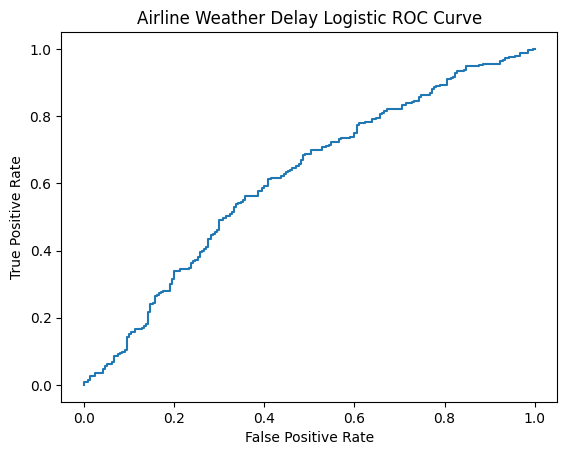

In [ ]:
# Create a Pipeline estimator and fit on train DF, predict on test DF
wlogr_best_predictions = wlogr_best_pipe.transform(w_testing_df)

# Returns as a list (false positive rate, true positive rate)
wlogr_best_preds = wlogr_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
wlogr_best_points = CurveMetrics(wlogr_best_preds).get_curve('roc')

plt.figure()
wlogr_best_x_val = [x[0] for x in wlogr_best_points]
wlogr_best_y_val = [x[1] for x in wlogr_best_points]
plt.title('Airline Weather Delay Logistic ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(wlogr_best_x_val, wlogr_best_y_val)

In [ ]:
#Get the coefficient values to determine how important each feature is to the model
wlogr_model = wlogr_best_pipe.stages[-1]
#Put in an array
wlog_array = wlogr_model.coefficients.toArray()
#Get the absolute value for each
wlog_abs = np.abs(wlog_array)
#Zip the coefficient weights with the coefficient names
wlog_best_df = pd.DataFrame(list(zip(weather_df.drop('label', 'IsDepartDelay', 'IsWeatherDelay', 'ArrivalDelay''ArrivalDelay', 'DepartDelay',
                                                'features', 'indexedFeatures', 'IsDepartDelay',
                                                'IsArrivalDelay').columns, wlog_abs)),
            columns = ['coefficient', 'weight']).sort_values('weight', ascending = False)

display(wlog_best_df)

,coefficient,weight
3,ExpectedArrivalTime,0.039947
0,Origin,0.011327
5,Distance,0.003673
8,Airline,0.003165
2,ExpectedDepartTime,0.000989
1,Dest,0.000642
6,DayOfMonth,0.000294
7,FlightMonth,0.000201
4,ArrivalDelay,0.000084


### Random Forest Classification Model: Weather Delay Prediction

In [ ]:
#Set maxBins =354 because there are 354 origin values
#Default RF model
wrf = RandomForestClassifier(maxBins=354)
wrf_pipeline = Pipeline(stages=[va, wrf]).fit(w_training_df)
bce.evaluate(wrf_pipeline.transform(w_validation_df))

0.7073658481305489

In [ ]:
#Create pipeline that is not fit on the training set yet
wrf_pipe = Pipeline(stages=[va, wrf])

if enable_grid_search:
      #Create grid
      wrf_grid = ParamGridBuilder().\
      addGrid(wrf.numTrees, [75, 90, 110]).\
      addGrid(wrf.maxDepth, [14, 15, 16]).\
      addGrid(wrf.minInstancesPerNode, [30, 35, 40]).\
      build()

      #Grid search
      wrf_all_models = []
      for j in range(len(wrf_grid)):
        wrf_model = wrf_pipe.fit(w_training_df, wrf_grid[j])
        wrf_all_models.append(wrf_model)

      #Get the AUC scores of each model on the grid
      #Create empty list that will be appended
      wrf_AUC_Scores = []
      #For each model in all models on the grid - obtain the AUC score
      for m in wrf_all_models:
        wrf_predictions = m.transform(w_validation_df)
        wrf_AUC_score = bce.evaluate(wrf_predictions, {bce.metricName: "areaUnderROC"})
        wrf_AUC_Scores.append(wrf_AUC_score)

      #Get index of the best model by using function argmax
      best_wrf_model_idx = np.argmax(wrf_AUC_Scores)
      best_wrf_model = wrf_all_models[best_wrf_model_idx]

      #Look at the corresponding grid index to find the hyper parameter values in the best model
      print(wrf_grid[best_wrf_model_idx])
      print("AUC on Validation Data = ", wrf_AUC_Scores[best_wrf_model_idx])
      pass

### Random Forest Classification Weather Grid Search:
First Grid: numTrees = [10, 20, 30], maxDepth = [3, 15], minInstancesPerNode = [5, 10, 15] \
Best Model: numTrees = 30, maxDepth = 15, minInstancesPerNode = 15, AUC = 0.6931

Second: numTrees = [50, 60, 75], maxDepth = [15, 20], minInstancesPerNode = [20, 25, 30] \
Best Model: numTrees = 75, maxDepth = 15, minInstancesPerNode = 30, AUC = 0.7033

Third Grid: numTrees = [75, 90, 110], maxDepth = [14, 15, 16], minInstancesPerNode = [30, 35, 40] \
Best Model: numTrees = 90, maxDepth = 14, minInstancesPerNode = 35, AUC = 0.7356



In [ ]:
#Hard code parameter values from the best outcome from the grid search
nt = 90
md = 14
fss = 'sqrt'
mipn = 35
mb = 354

#Create new random forest regressor with hard coded best model hyper params
best_wrf = RandomForestClassifier().\
    setLabelCol('label').\
    setFeaturesCol('features').\
    setNumTrees(nt).\
    setMaxBins(mb).\
    setFeatureSubsetStrategy(fss).\
    setMinInstancesPerNode(mipn).\
    setMaxDepth(md)

#Create the pipeline
best_wrf_pipe = Pipeline(stages=[va, best_wrf]).fit(w_training_df)

#Test best_pipe
wrf_test_auc = bce.evaluate(best_wrf_pipe.transform(w_testing_df))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


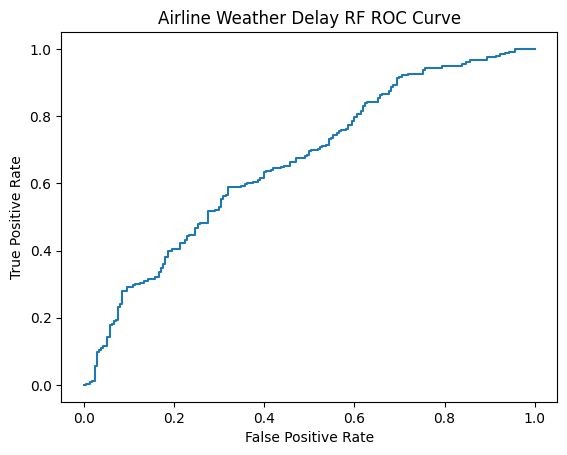

In [ ]:
# Create a Pipeline estimator and fit on train DF, predict on test DF
wrf_best_predictions = best_wrf_pipe.transform(w_testing_df)

# Returns as a list (false positive rate, true positive rate)
wrf_best_preds = wrf_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
wrf_best_points = CurveMetrics(wrf_best_preds).get_curve('roc')

#Build Plot
plt.figure()
wrf_best_x_val = [x[0] for x in wrf_best_points]
wrf_best_y_val = [x[1] for x in wrf_best_points]
plt.title('Airline Weather Delay RF ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(wrf_best_x_val, wrf_best_y_val)

In [ ]:
#Get feature importance
#Call on the random forest stage of the pipeline
wrf_best_model = best_wrf_pipe.stages[-1]

#Send the feature importances from that stage to an array
wrf_array = wrf_best_model.featureImportances.toArray()

#Zip the necessary column names with the feature importance array
wrf_best_df = pd.DataFrame(list(zip(weather_df.drop('label', 'IsDepartDelay', 'IsWeatherDelay', 'ArrivalDelay''ArrivalDelay', 'DepartDelay',
                                                'features', 'IsDepartDelay',
                                                'IsArrivalDelay').columns, wrf_array)),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

#Display the feature importance results
display(wrf_best_df)

,feature,importance
1,Dest,0.442069
2,ExpectedDepartTime,0.308139
6,DayOfMonth,0.064137
0,Origin,0.058486
7,FlightMonth,0.042495
4,ArrivalDelay,0.026433
3,ExpectedArrivalTime,0.025837
8,Airline,0.016339
5,Distance,0.016064


### Gradient-Boosted Trees Classification Model: Weather Delay Prediction

In [ ]:
#Default GBT Model
wgbt = GBTClassifier(maxBins=354)
wgbt_pipeline = Pipeline(stages=[va, wgbt]).fit(w_training_df)
bce.evaluate(wgbt_pipeline.transform(w_validation_df))

0.6553893256846326

In [ ]:
#Create pipeline without fit on training
wgbt_pipe = Pipeline(stages=[va, wgbt])

if enable_grid_search:
      #Create grid
      wgbt_grid = ParamGridBuilder().\
          addGrid(gbt.subsamplingRate, [0.55, 0.65]).\
          addGrid(gbt.maxIter, [30]).\
          addGrid(gbt.stepSize, [0.07, 0.08, 0.09]).\
          addGrid(gbt.maxDepth, [3]).\
          build()

      #Grid search
      wgbt_all_models = []
      for j in range(len(wgbt_grid)):
        wgbt_model = wgbt_pipe.fit(w_training_df, wgbt_grid[j])
        wgbt_all_models.append(wgbt_model)

      #Get the AUC scores of each model on the grid
      #Create empty list that will be appended
      wgbt_AUC_Scores = []
      #For each model in all models on the grid - obtain the AUC score
      for m in wgbt_all_models:
        wgbt_predictions = m.transform(w_validation_df)
        wgbt_AUC_score = bce.evaluate(wgbt_predictions, {bce.metricName: "areaUnderROC"})
        wgbt_AUC_Scores.append(wgbt_AUC_score)

      #Get index of the best model by using function argmax
      best_wgbt_model_idx = np.argmax(wgbt_AUC_Scores)
      best_wgbt_model = wgbt_all_models[best_wgbt_model_idx]

      #Look at the corresponding grid index to find the hyper param values in the best model
      print(wgbt_grid[best_wgbt_model_idx])
      print("AUC on Validation Data = ", wgbt_AUC_Scores[best_wgbt_model_idx])

### GBT Model Weather Grid Search:
First: subsamplingRate = [0.8, 0.85], maxIter = [30, 35], stepSize = [0.2, 0.22, 0.24], maxDepth = [4] \
Best Model: subsamplingRate = 0.8, maxIter = 30, stepSize = 0.2, maxDepth = 4, AUC = 0.6002 \
Second: subsamplingRate = [0.75, 0.8, 0.85], maxIter = [20, 30, 50], stepSize = [0.05, 0.1, 0.2], maxDepth = [3, 4, 5] \
Best Model: subsamplingRate = 0.75, maxIter = 30, stepSize = 0.1, maxDepth = 3, AUC = 0.6002 \

Third: subsamplingRate = [0.65, 0.75], maxIter = [30], stepSize = [0.08, 0.1, 0.12], maxDepth = [3] \
Best Model: subsamplingRate = 0.65, maxIter = 30, stepSize = 0.08, maxDepth = 3, AUC = 0.6334



In [ ]:
#Hard code parameter values from the best outcome from the grid search
ssr = 0.65
mi = 30
ss = 0.08
md = 3
mb= 354

#Create new random forest regressor with hard coded best model hyper params
best_wgbt = GBTClassifier().\
    setLabelCol('label').\
    setFeaturesCol('features').\
    setSubsamplingRate(ssr).\
    setMaxIter(mi).\
    setStepSize(ss).\
    setMaxBins(mb).\
    setMaxDepth(md)

#Create the pipeline
best_wgbt_pipe = Pipeline(stages=[va, best_wgbt]).fit(w_training_df)

#Test best_pipe
wgbt_test_auc = bce.evaluate(best_wgbt_pipe.transform(w_testing_df))
bce.evaluate(best_wgbt_pipe.transform(w_testing_df))

0.5599472990777339

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


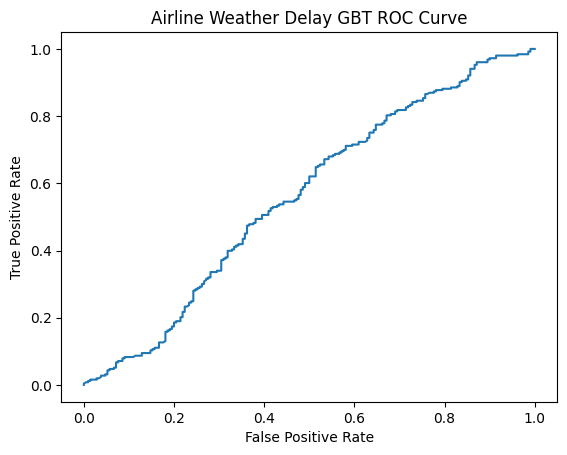

In [ ]:
# Get predictions from the best pipeline
wgbt_best_predictions = best_wgbt_pipe.transform(w_testing_df)

# Returns as a list (false positive rate, true positive rate)
wgbt_best_preds = wgbt_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
wgbt_best_points = CurveMetrics(wgbt_best_preds).get_curve('roc')

plt.figure()
wgbt_best_x_val = [x[0] for x in wgbt_best_points]
wgbt_best_y_val = [x[1] for x in wgbt_best_points]
plt.title('Airline Weather Delay GBT ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(wgbt_best_x_val, wgbt_best_y_val)

In [ ]:
#Call on the gradient-boosted trees stage of the pipeline
wgbt_best_model = best_wgbt_pipe.stages[-1]

#Send the feature importances from that stage to an array
wgbt_array = wgbt_best_model.featureImportances.toArray()

#Zip the necessary column names with the feature importance array
wgbt_best_df = pd.DataFrame(list(zip(weather_df.drop('label', 'IsDepartDelay', 'IsWeatherDelay', 'ArrivalDelay''ArrivalDelay', 'DepartDelay',
                                                'features', 'IsDepartDelay',
                                                'IsArrivalDelay').columns, wgbt_array)),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

#Display the feature importance results
display(wgbt_best_df)

,feature,importance
2,ExpectedDepartTime,0.501699
1,Dest,0.444953
6,DayOfMonth,0.023838
0,Origin,0.022695
7,FlightMonth,0.004885
3,ExpectedArrivalTime,0.001930
4,ArrivalDelay,0.000000
5,Distance,0.000000
8,Airline,0.000000


### Model Comparison: Weather Delay Prediction

In [ ]:
# Create model comparison df
#Create list with specified model labels
labels = ['LogReg', 'RF', 'GBT']
#Create list of results from each model
scores = [wlogr_test_auc, wrf_test_auc, wgbt_test_auc]
#Zip the two lists together, and sort values by AUC in descending order - highest at the top
#Had to round the df to the nearest 2 decimals, otherwise AUC value output was returned in scientific notation
weather_delay_compare_df = pd.DataFrame(list(zip(labels, scores)),
            columns = ['Model', 'AUC']).sort_values('AUC', ascending = True).round(4)

#Return output
display(weather_delay_compare_df)

,Model,AUC
2,GBT,0.5599
0,LogReg,0.6131
1,RF,0.6643


# Logistic or Linear Regression Model: Predicting Likelihood a Flight Will Not Depart On Time
One of our original prediction models described in the project proposal was to predict whether a flight will leave on time or not. This could be measured how the other two models were - create a new column with a binary value that will return 1 if the *DEP_DELAY* is > 0.0, and 0 if otherwise.

In [ ]:
time_df = delay_df_xformed.withColumnRenamed('IsDepartDelay', 'label')
time_training_df, time_validation_df, time_testing_df = time_df.randomSplit([0.6, 0.3, 0.1], )

### Logistic Regression Model: Departure Delay Prediction

In [ ]:
tlogr = LogisticRegression(regParam=0.1)
tlogr_pipeline = Pipeline(stages=[va, tlogr]).fit(time_training_df)
bce = BinaryClassificationEvaluator()
bce.evaluate(tlogr_pipeline.transform(time_validation_df))

0.6281324928975723

In [ ]:
tlogr_pipe = Pipeline(stages=[va, tlogr])
if enable_grid_search:
      #Create grid
      tlogr_grid = ParamGridBuilder().\
      addGrid(tlogr.regParam, [0.22, 0.25, 0.28]).\
      addGrid(tlogr.elasticNetParam, [0.0065, 0.0075, 0.0085]).\
      build()

      #Grid search - fit with training data
      tlogr_all_models = []
      for j in range(len(tlogr_grid)):
        tlogr_model = tlogr_pipe.fit(time_training_df, tlogr_grid[j])
        tlogr_all_models.append(tlogr_model)

      #Get the AUC scores of each model on the grid
      #Create empty list that will be appended
      tlogr_AUC_Scores = []
      #For each model in all models on the grid - obtain the AUC score
      for m in tlogr_all_models:
        tlogr_predictions = m.transform(time_validation_df)
        tlogr_AUC_score = bce.evaluate(tlogr_predictions, {bce.metricName: "areaUnderROC"})
        tlogr_AUC_Scores.append(tlogr_AUC_score)

      #Get index of the best model by using function argmin - the lower the AUC score the better
      best_tlogr_model_idx = np.argmax(tlogr_AUC_Scores)
      best_tlogr_model = tlogr_all_models[best_tlogr_model_idx]

      #Look at the corresponding grid index to find the hyper parameter values in the best model
      print(tlogr_grid[best_tlogr_model_idx])
      print("AUC on Validation Data = ", tlogr_AUC_Scores[best_tlogr_model_idx])
      pass

### Random Forest Classification Model: Departure Delay Prediction

In [ ]:
trfc = RandomForestClassifier(maxBins=354)
trfc_pipeline = Pipeline(stages=[va, trfc]).fit(time_training_df)
bce.evaluate(trfc_pipeline.transform(time_validation_df))

0.6535589200814049

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


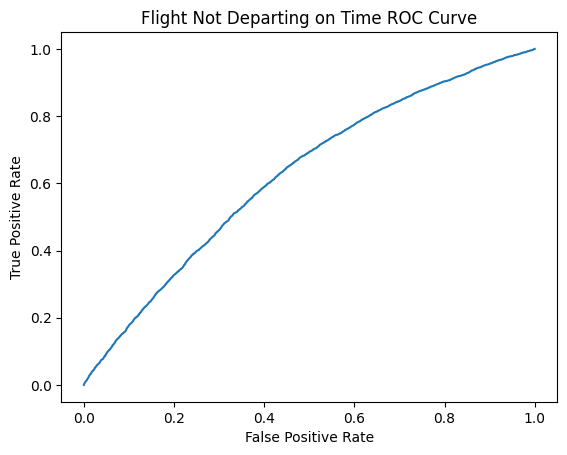

In [ ]:
# Create a Pipeline estimator and fit on train DF, predict on test DF
tpredictions = tlogr_pipeline.transform(time_testing_df)

# Returns as a list (false positive rate, true positive rate)
tpreds = tpredictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
tpoints = CurveMetrics(tpreds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in tpoints]
y_val = [x[1] for x in tpoints]
plt.title('Flight Not Departing on Time ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [ ]:
tlogr_model = tlogr_pipeline.stages[-1]

trfc_model = trfc_pipeline.stages[-1]

t_array = trfc_model.featureImportances.toArray()

t_abs = np.abs(t_array)

In [ ]:
tpredictions = tlogr_pipeline.transform(time_testing_df)
tpredictions.show(5)

+------+----+------------------+-----------+-------------------+------------+--------+----------+-----------+--------------+-----+--------------+-------+------+--------------------+--------------------+--------------------+----------+
|Origin|Dest|ExpectedDepartTime|DepartDelay|ExpectedArrivalTime|ArrivalDelay|Distance|DayOfMonth|FlightMonth|IsWeatherDelay|label|IsArrivalDelay|Airline|Season|            features|       rawPrediction|         probability|prediction|
+------+----+------------------+-----------+-------------------+------------+--------+----------+-----------+--------------+-----+--------------+-------+------+--------------------+--------------------+--------------------+----------+
|   0.0| 1.0|               907|        7.0|               1013|        21.0|   606.0|         3|          4|             0|    1|             1|    1.0|   1.0|[1.0,0.0,1.0,1.0,...|[0.78352866074998...|[0.68644012237183...|       0.0|
|   0.0| 1.0|              1510|       15.0|               1

In [ ]:
rf2_df = pd.DataFrame(list(zip(time_df.drop('label', 'IsWeatherDelay', 'ArrivalDelay',
                                                'AirTime', 'features', 'indexedFeatures',
                                                'IsArrivalDelay').columns, t_abs)),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

display(rf2_df)

,feature,importance
0,Origin,0.370262
6,DayOfMonth,0.298297
7,FlightMonth,0.236685
1,Dest,0.035337
3,DepartDelay,0.033925
2,ExpectedDepartTime,0.016179
4,ExpectedArrivalTime,0.007594
8,Airline,0.001456
5,Distance,0.000264


In [ ]:
# Create model comparison df
#Create list with specified model labels
labels = ['LogR', 'RF']
logreee_mse = tlogr_AUC_Scores[best_tlogr_model_idx]
rf_MSE3 = bce.evaluate(trfc_pipeline.transform(time_validation_df))

#Create list of results from each model
scores = [logreee_mse, rf_MSE3]
#Zip the two lists together, and sort values by AUC in descending order - highest at the top
#Had to round the df to the nearest 2 decimals, otherwise AUC value output was returned in scientific notation
d_delay_compare_df = pd.DataFrame(list(zip(labels, scores)),
            columns = ['Model', 'AUC']).sort_values('AUC', ascending = True).round(4)

#Return output
display(d_delay_compare_df)

,Model,AUC
0,LogR,0.6284
1,RF,0.6534


# Model Output Interpretations

### Linear Regression Model: Predicting How Long a Delay Will Be
We created a linear regression model, a random forest regression mode, and a GBT regression model to predict Arrival Delay.  The MSE scores for the two models were 2101.875 , 2097.514, and 2312.970 respectively, meaning that the random forest regression model performed slightly better than the linear regression model and GBT regression in predicting Arrival Delay.  The most important features for the linear regression model were Expected Depart Time and Season, while the least important features were Distance and Origin.  This result was not that surprising; however, the most important features for the random forest regression model and GBT regression model were Distance and Destination, while the least important features were Airline and Flight Month.  This was surprising because the Distance variable was had a complete opposite effect on the different models in terms of the feature importance , and also because I would have thought the Flight Month variable would have more importance in the random forest and GBT regression models.


### Logistic Regression Model: Predicting Likelihood a Flight Will Be Delayed
Variable importance, interesting insights, etc.

We created a logistic regression and a random forest model. However, the random forest model was stronger, so we looked at the feature importance of the model. We found season and ExpectDepartTOD were the two most important features of the random forest model. This makes sense as if the actual depart time is greater than the expected depart time, there must be a delay. Season also makes sense as weather may have an effect in delay potential in the winter. Besides these two, Destination was significant (might be other delays at busy arrival airports) along with DayOfMonth and Distance.

### Logistic Regression Model: Predicting Likelihood a Flight Will Be Delayed By Weather
It seems as though Airline and Origin are the most important features for predicting a weather delay using the logistic regression model. As for the random forest model, it looks like expected depature time and destination are the most important features for predicting a weather delay. The random forest model is more accurate, but the feature importance rankings seem counterintuitive. I would think that, Airline, Origin, and Flight Month would be the most important - but Airline and Flight Month are the bottom two for the random forest model.

### Logistic Regression Model: Predicting Likelihood a Flight Will Not Depart On Time
When discovering important features to a model that predicts whether flights will have a departure delay, we find that the biggest factors without a doubt are the origin location of the flight, the airline operating the flight, and the season in which the flight takes place. When thinking about what causes a flight to depart late, these two features being extremely important is not at all surprising, as departure delays happen more often because of the origin airport, issues with the airline before takeoff, or also with weather issues caused by the various seasons, or higher seasonal airport traffic.